In [64]:
%config InlineBackend.figure_format = 'retina'

import numpy as np

In [2]:
list_SD36 = ['6x2pt_WFIRSTwidexSO5','6x2pt_WFIRSTstdxSO5']
list_COV36 = ['cov_wfirstwidexso_6x2pt.npy','cov_wfirststdxso_6x2pt.npy']

list_outfiles = ['6x2pt_WFIRSTwidexSO5','6x2pt_WFIRSTstdxSO5','3x2pt_WFIRSTwidexSO5','3x2pt_WFIRSTstdxSO5']

dir_datav = "datav/"
dir_bary = "datav/"
dir_COV = "cov/"
dir_LPC = "baryons/"

In [4]:
class gen_LPCi():
    def __init__(self,id_SD,outfile,id_include=None):
        '''
            id_SD = 0~1, int
        '''
        self.id_SD = id_SD
        self.id_include = id_include
        self.outfile = outfile
        self.list_bary_scenario = ['_eagle','_illustris','_TNG100','_mb2','_owls_AGN','_HzAGN']
        self.datav_dmo = self.load_datav(dir_datav,bary_scenario="_dmo",isCutted=1)
        print(self.id_SD)
        print(self.id_include)
        
        self.load_COV()
        print(self.id_SD)
        print(self.datav_dmo.shape, self.COV_cut.shape)
        
        self.cal_invL()
        self.Ndata = len(self.datav_dmo)
        self.Nscenario = len(self.list_bary_scenario)
        
        self.build_Ratio()
        self.build_Delta()
        self.build_DeltaChy()
        self.SVD(in_Delta=self.DeltaChy)
        self.write_LPC()
        
    
    def load_datav(self,dir_path,bary_scenario,isCutted=0):
        fname_datav = dir_path+list_SD36[self.id_SD]+bary_scenario
        print(fname_datav)
        datav = np.genfromtxt(fname_datav,skip_header=0,dtype="int,double",usecols=[0,1],names=["ind","obs"])["obs"]
        if self.id_include is None:
            self.id_include = np.arange(datav.size)
        datav = datav[self.id_include]
        
        self.Ndata_full  = len(datav)
        self.takeout_ID  = np.where(datav > 1e-20)[0]
        self.zero_ID     = np.where(datav < 1e-20)[0]
        
        if isCutted==1:
            return np.array(datav)[self.takeout_ID]
        else:
            return np.array(datav)
        
            
    def load_COV(self):
        
        self.fname_COV = dir_COV+list_COV36[self.id_SD]
        print(self.fname_COV)
        self.COV_full = np.load(self.fname_COV)
        self.COV_full = self.COV_full[self.id_include][:,self.id_include]
        
        self.COV_cut  = self.COV_full[self.takeout_ID][:,self.takeout_ID]
    
    
    def cal_invL(self):
        self.L    = np.linalg.cholesky(self.COV_cut)
        self.invL =  np.linalg.inv(self.L)
        
    def build_Ratio(self):
        self.Ratio     = np.zeros((self.Ndata,self.Nscenario))
        
        for j in range(self.Nscenario):
        
            datav_bary = self.load_datav(dir_bary,bary_scenario=self.list_bary_scenario[j],isCutted=1)
            self.Ratio.T[j] = datav_bary/self.datav_dmo
            
    def build_Delta(self):
        DeltaT = self.Ratio.T*self.datav_dmo-self.datav_dmo
        self.Delta = DeltaT.T
    
    def build_DeltaChy(self):
        self.DeltaChy = np.dot(self.invL,self.Delta)
        
    def SVD(self,in_Delta):
        # self.U stores PC modes
        # PC1 = self.U.T[0]  ; PC2 = self.U.T[1]
        self.U, self.Sdig, VT = np.linalg.svd(in_Delta,full_matrices=True)
    
    def gen_datav_cosmolike_format(self,datav_cut):
        
        datav_full = np.zeros(self.Ndata_full)
        datav_full[self.takeout_ID] = datav_cut
        
        return datav_full

    
    def write_LPC(self):
        
        self.fname_out = dir_LPC+'LPC_'+self.outfile
        
        self.LPC1 = self.gen_datav_cosmolike_format(np.dot(self.L,self.U.T[0]))
        self.LPC2 = self.gen_datav_cosmolike_format(np.dot(self.L,self.U.T[1]))
        self.LPC3 = self.gen_datav_cosmolike_format(np.dot(self.L,self.U.T[2]))
        self.LPC4 = self.gen_datav_cosmolike_format(np.dot(self.L,self.U.T[3]))
        self.LPC5 = self.gen_datav_cosmolike_format(np.dot(self.L,self.U.T[4]))
        self.LPC6 = self.gen_datav_cosmolike_format(np.dot(self.L,self.U.T[5]))
        
        col_names='LPC1 LPC2 LPC3 LPC4 LPC5 LPC6'
        
        LPC_Matrix=np.column_stack((self.LPC1,self.LPC2,self.LPC3,self.LPC4,self.LPC5,self.LPC6))

        np.savetxt(self.fname_out,LPC_Matrix, fmt='%.8e %.8e %.8e %.8e %.8e %.8e')

       

In [7]:
PCA = gen_LPCi(0, list_outfiles[0])
# gen_LPCi(1, list_outfiles[1])

datav/6x2pt_WFIRSTwidexSO5_dmo
0
[   0    1    2 ... 1767 1768 1769]
cov/cov_wfirstwidexso_6x2pt.npy
0
(1518,) (1518, 1518)
datav/6x2pt_WFIRSTwidexSO5_eagle
datav/6x2pt_WFIRSTwidexSO5_illustris
datav/6x2pt_WFIRSTwidexSO5_TNG100
datav/6x2pt_WFIRSTwidexSO5_mb2
datav/6x2pt_WFIRSTwidexSO5_owls_AGN
datav/6x2pt_WFIRSTwidexSO5_HzAGN


In [104]:
datav_eagle = PCA.load_datav(dir_path=dir_datav, bary_scenario='_eagle', isCutted=1)
datav_illustris = PCA.load_datav(dir_path=dir_datav, bary_scenario='_illustris', isCutted=1)
datav_dmo       = PCA.load_datav(dir_path=dir_datav, bary_scenario='_dmo', isCutted=1)

invLDiff_illustris = np.dot(PCA.invL, datav_illustris-datav_dmo)
invLDiff_eagle = np.dot(PCA.invL, datav_eagle-datav_dmo)
invLDiff_dmo = np.dot(PCA.invL, datav_dmo-datav_dmo)

datav/6x2pt_WFIRSTwidexSO5_eagle
datav/6x2pt_WFIRSTwidexSO5_illustris
datav/6x2pt_WFIRSTwidexSO5_dmo


In [105]:
def cal_Qexp(scenario):
    datav_bary = PCA.load_datav(dir_path=dir_datav, bary_scenario='_'+scenario, isCutted=1)
    diff = datav_bary - PCA.datav_dmo
    diff_chy = np.dot(PCA.invL, diff)
    Qexp = np.dot(PCA.U.T,diff_chy)
    return Qexp

In [106]:
Qexp_illustris = cal_Qexp(scenario='illustris')
Qexp_eagle     = cal_Qexp(scenario='eagle')
Qexp_dmo       = cal_Qexp(scenario='dmo')

datav/6x2pt_WFIRSTwidexSO5_illustris
datav/6x2pt_WFIRSTwidexSO5_eagle
datav/6x2pt_WFIRSTwidexSO5_dmo


In [107]:
Qexp_eagle[0:4]

array([ 9.36396658,  4.12442005,  1.23283641, -0.82477876])

In [108]:
Qexp_illustris[0:4]

array([74.27759509, -4.65573467,  1.58921146, -0.14868739])

In [122]:
def dataV_PCcon(Qexp):
    
    sumPC = 0.
    
    #for j in range(len(Qexp)):
    #    sumPC = sumPC + Qexp[j]*PCA.U.T[j]
    #Dv_PCcon = PCA.datav_dmo + np.dot(PCA.L, sumPC)
    
    for j in range(len(Qexp)):
        sumPC = sumPC + Qexp[j]*np.dot(PCA.L, PCA.U.T[j])
    Dv_PCcon = PCA.datav_dmo + sumPC
    
    return Dv_PCcon

# plot dataV with Qi

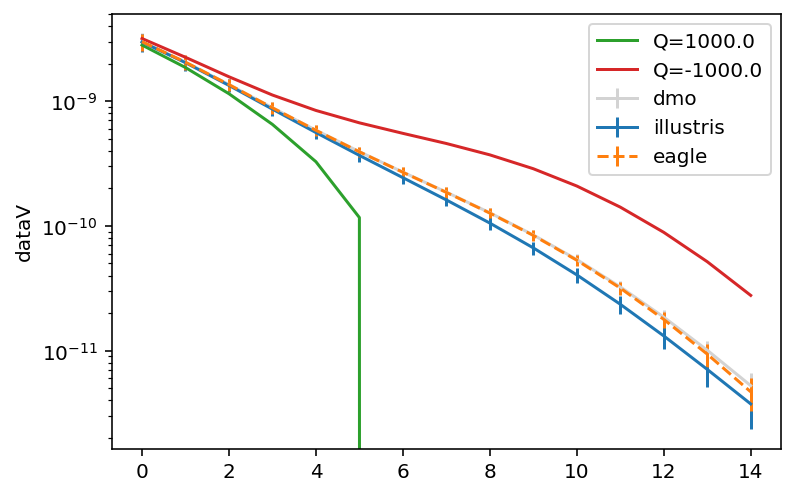

In [163]:
Qup, Qlo = 1000., -1000.
datav_Qup = dataV_PCcon(Qexp = [Qup])
datav_Qlo = dataV_PCcon(Qexp = [Qlo])

################

%matplotlib inline

IDst, IDcut = 0, 15
err = np.sqrt(PCA.COV_cut.diagonal())
plt.errorbar(np.arange(1518)[IDst:IDcut], datav_dmo[IDst:IDcut], yerr=err[IDst:IDcut], label='dmo', color='lightgray')

plt.errorbar(np.arange(1518)[IDst:IDcut], datav_illustris[IDst:IDcut], yerr=err[IDst:IDcut], label='illustris')

plt.errorbar(np.arange(1518)[IDst:IDcut], datav_eagle[IDst:IDcut], yerr=err[IDst:IDcut], label='eagle', ls='--')


plt.plot(np.arange(1518)[IDst:IDcut], datav_Qup[IDst:IDcut], label=f'Q={Qup}')
plt.plot(np.arange(1518)[IDst:IDcut], datav_Qlo[IDst:IDcut], label=f'Q={Qlo}')


plt.ylabel('dataV')
plt.yscale('log')
plt.legend()
#plt.plot(np.arange(1518)[0:200], datav_illustris[0:200])

# compare Illustris v.s. theoretichal Q1 value of illustris 

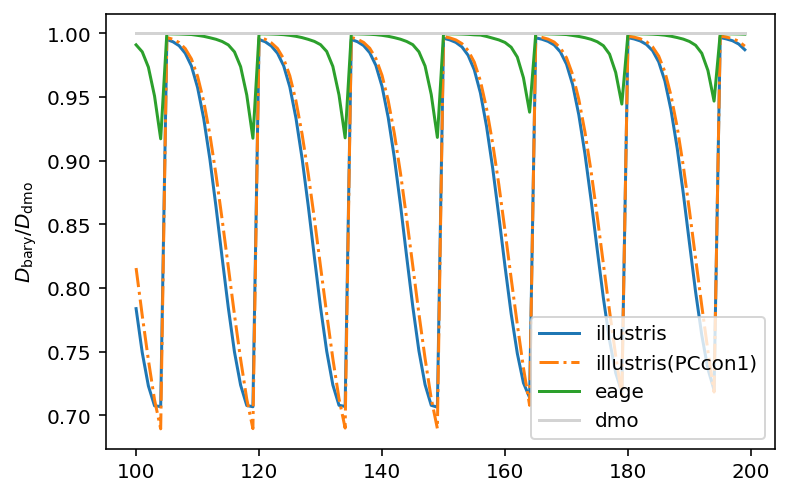

In [141]:
datav_illustris_PCcon2 = dataV_PCcon(Qexp = Qexp_illustris[0:1])

###############

%matplotlib inline

IDst, IDcut = 100, 200

plt.plot(np.arange(1518)[IDst:IDcut], datav_illustris[IDst:IDcut]/datav_dmo[IDst:IDcut], label='illustris')
plt.plot(np.arange(1518)[IDst:IDcut], datav_illustris_PCcon2[IDst:IDcut]/datav_dmo[IDst:IDcut], label='illustris(PCcon1)',ls='-.')
plt.plot(np.arange(1518)[IDst:IDcut], datav_eagle[IDst:IDcut]/datav_dmo[IDst:IDcut], label='eage')
plt.plot(np.arange(1518)[IDst:IDcut], datav_dmo[IDst:IDcut]/datav_dmo[IDst:IDcut], label='dmo',color='lightgray')


plt.ylabel('$D_{\\rm bary}/D_{\\rm dmo}$')
plt.legend()

# plot DeltaChy=L$^{-1}$ (D$_{\rm bary}$-D$_{\rm dmo}$) matrix

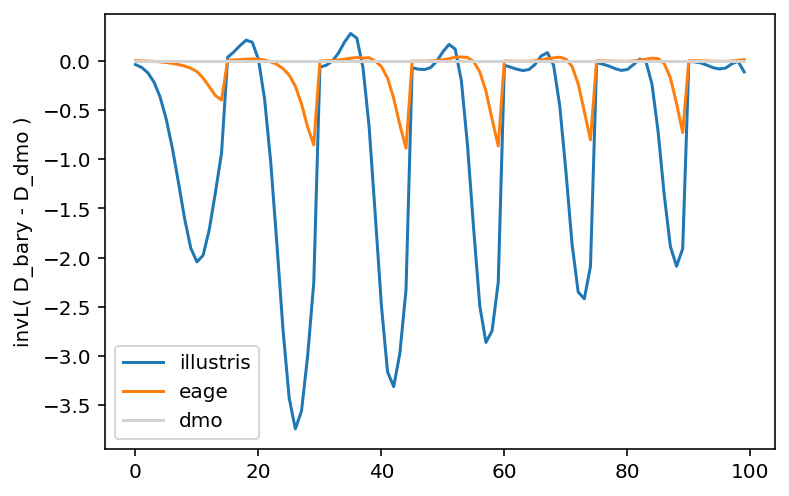

In [118]:
%matplotlib inline

# plot weighted difference matrix
IDst, IDcut = 0, 100
plt.plot(np.arange(1518)[IDst:IDcut], invLDiff_illustris[IDst:IDcut], label='illustris')
plt.plot(np.arange(1518)[IDst:IDcut], invLDiff_eagle[IDst:IDcut], label='eage')
plt.plot(np.arange(1518)[IDst:IDcut], invLDiff_dmo[IDst:IDcut], label='dmo',color='lightgray')


plt.ylabel('invL( D_bary - D_dmo )')
plt.legend()

# plot PCs (looks good c.p. to fig. above)
### the magnitude of each PC mode is normalized

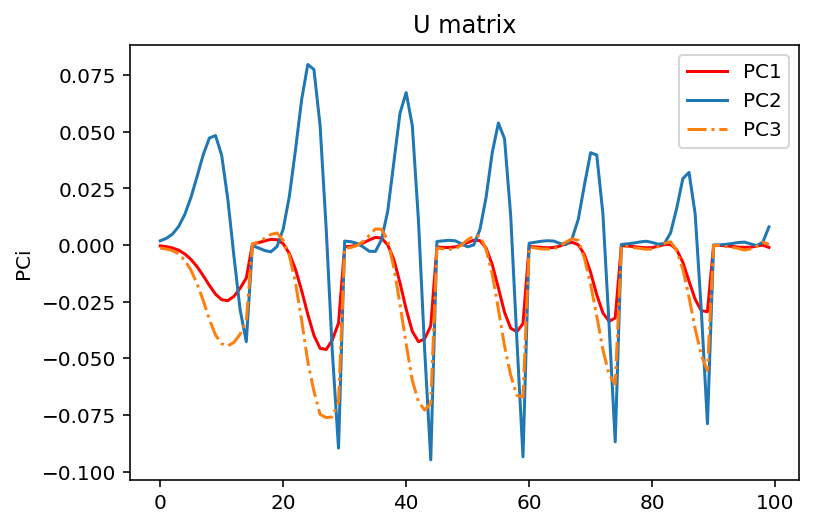

In [164]:
%matplotlib inline

# plot PCs 

IDst, IDcut = 0, 100

plt.plot(np.arange(1518)[IDst:IDcut], PCA.U.T[0][IDst:IDcut], label='PC1', color='red')
plt.plot(np.arange(1518)[IDst:IDcut], PCA.U.T[1][IDst:IDcut], label='PC2')
plt.plot(np.arange(1518)[IDst:IDcut], PCA.U.T[2][IDst:IDcut], label='PC3',ls='-.')

plt.ylabel('PCi')
plt.title('U matrix')

plt.legend()

# check L PCi (the order of 1e-12 comes from L)

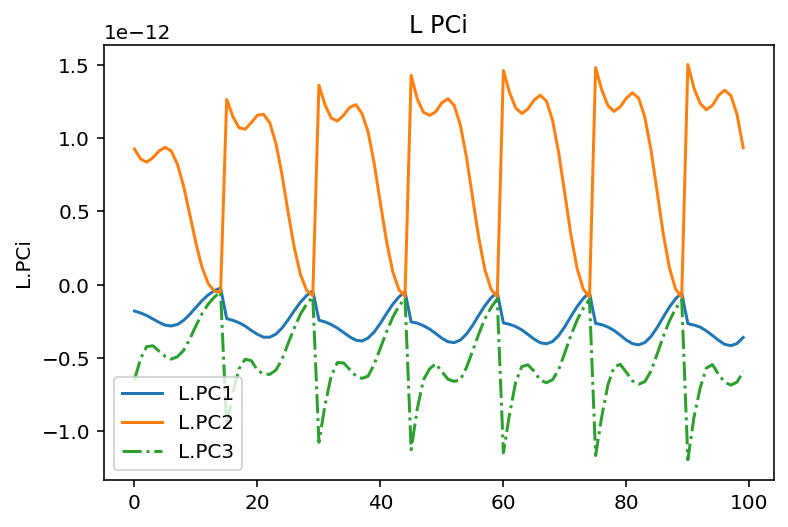

In [132]:

# plot L PCs 

IDst = 0
IDcut = 100

plt.plot(np.arange(1518)[IDst:IDcut], np.dot(PCA.L, PCA.U.T[0])[IDst:IDcut], label='L.PC1')
plt.plot(np.arange(1518)[IDst:IDcut], np.dot(PCA.L, PCA.U.T[1])[IDst:IDcut], label='L.PC2')
plt.plot(np.arange(1518)[IDst:IDcut], np.dot(PCA.L, PCA.U.T[2])[IDst:IDcut], label='L.PC3',ls='-.')

plt.ylabel('L.PCi')
plt.title('L PCi')
#plt.yscale('log')

plt.legend()